<a href="https://colab.research.google.com/github/chrisrichardson/linear-algebra/blob/main/07_Multigrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multigrid

Multigrid gives us faster convergence with an iterative method, because it smooths out the low frequency component of the error more quickly.
Like other iterative methods, it has its shortcomings, and doesn't work well for every problem.

We will look at `pyamg` which is an implementation of Algebraic Multigrid (AMG).

In [15]:
!pip install pyamg
import pyamg
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Start with a standard Poisson problem (small)
n = 10
A = pyamg.gallery.poisson((n, n, n)).tocsr()
b = np.ones(A.shape[1])

### Create a multigrid hierarchy based on the connectivity of A.
There are various algorithms for aggregating the entries of the "fine operator" and computing a coarser one. `pyamg` implements a few different ones, and there are also parameters you can supply to guide the aggregation.

Try:
`pyamg.ruge_stuben_solver(A)`
or
`pyamg.smoothed_aggregation_solver(A)`
or
`pyamg.rootnode_solver(A)`

Check out the `help()` for each of these, and try setting some parameters (e.g. strength of connection 'strength' or the maximum number of levels 'max_levels').




In [42]:
help(pyamg.ruge_stuben_solver)

Help on function ruge_stuben_solver in module pyamg.classical.classical:

ruge_stuben_solver(A, strength=('classical', {'theta': 0.25}), CF=('RS', {'second_pass': False}), interpolation='classical', presmoother=('gauss_seidel', {'sweep': 'symmetric'}), postsmoother=('gauss_seidel', {'sweep': 'symmetric'}), max_levels=30, max_coarse=10, keep=False, **kwargs)
    Create a multilevel solver using Classical AMG (Ruge-Stuben AMG).
    
    Parameters
    ----------
    A : csr_matrix
        Square matrix in CSR format
    strength : str
        Valid strings are ['symmetric', 'classical', 'evolution', 'distance',
        'algebraic_distance','affinity', 'energy_based', None].
        Method used to determine the strength of connection between unknowns
        of the linear system.  Method-specific parameters may be passed in
        using a tuple, e.g. strength=('symmetric',{'theta': 0.25 }). If
        strength=None, all nonzero entries of the matrix are considered strong.
    CF : str or

In [45]:
# Create an AMG solver based on A using default options
ml = pyamg.ruge_stuben_solver(A)
# Print out a summary
print(ml)

MultilevelSolver
Number of Levels:     5
Operator Complexity:   2.496
Grid Complexity:       1.598
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0        1000         6400 [40.06%]
     1         500         7760 [48.57%]
     2          83         1653 [10.35%]
     3          13          159 [1.00%]
     4           2            4 [0.03%]



### Understanding AMG

We can plot the non-zero pattern for each level, which will give us an intuitive idea about what is going on. As aggregation proceeds, each level gets successively smaller, but also denser.
At the coarsest level, it is fully dense, so pyamg just uses an LU solver for this.

We can also look at the interpolation operator (a rectangular matrix) - usually given the symbols `R` and `P` for restriction (fine to coarse) and prolongation (coarse to fine).

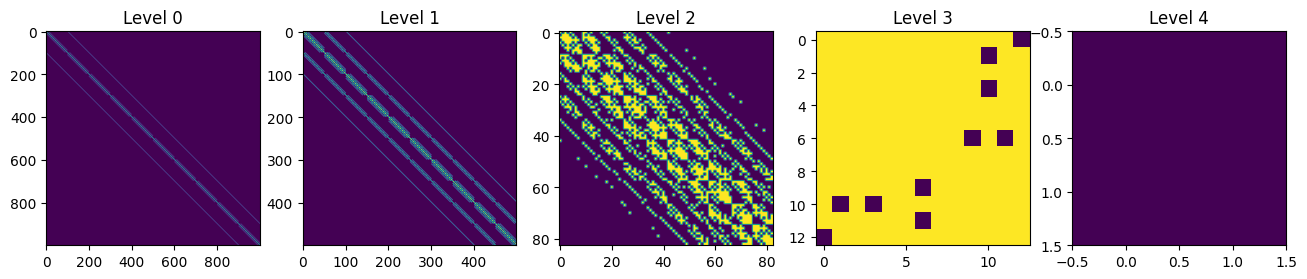

In [46]:
plt.figure(figsize=(16,4))
for i in range(len(ml.levels)):
  plt.subplot(1, len(ml.levels), i+1)
  plt.imshow(ml.levels[i].A.todense() != 0)
  plt.title(f'Level {i}')
plt.show()

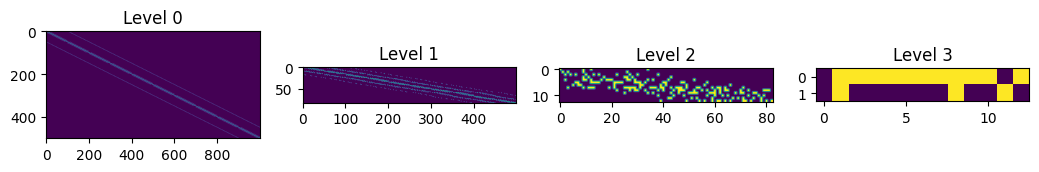

In [36]:
plt.figure(figsize=(16,4))
for i in range(len(ml.levels) - 1):
  plt.subplot(1, len(ml.levels), i+1)
  plt.imshow(ml.levels[i].R.todense() != 0)
  plt.title(f'Level {i}')
plt.show()

### Solving

`pyamg` makes it easy to solve - just use the `ml.solve()` function. Again, there are some options, so worth checking out the `help()`.
You can set the tolerance (`tol`) and also apply an outer solver (`accel`) to speed things up.

In theory, the number of iterations should not really change as we increase the problem size (though it might do a bit).

In [70]:
# Let's make the problem bigger
n = 80
A = pyamg.gallery.poisson((n, n, n)).tocsr()
b = np.ones(A.shape[1])
ml = pyamg.ruge_stuben_solver(A)

6.220234310311646e-10


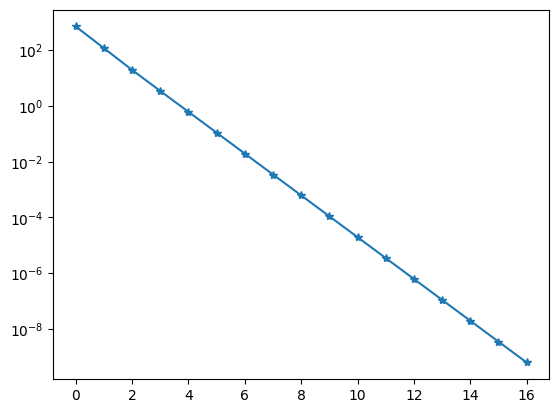

In [71]:
r = []
x = ml.solve(b, tol=1e-12, residuals=r)
print(np.linalg.norm(A @ x - b))
plt.plot(r, marker='*')
plt.yscale('log')
plt.show()

2.8778109183345514e-10


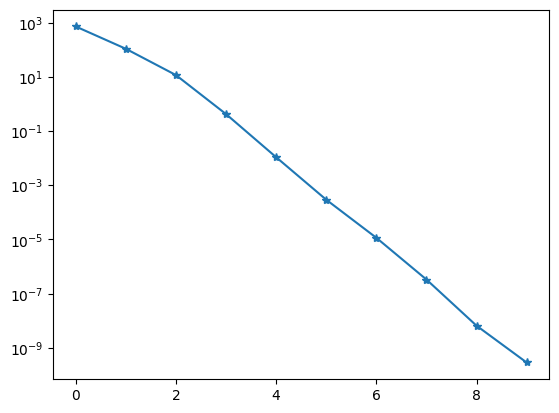

In [72]:
r = []
x = ml.solve(b, tol=1e-12, residuals=r, accel='cg')
print(np.linalg.norm(A @ x - b))
plt.plot(r, marker='*')
plt.yscale('log')
plt.show()

`pyamg` has other examples in the gallery, including "linear elasticity". There are also a load of examples on their GitHub pages.
It's worth having a play around with it...